# Tutorial: Clasificación con k-Nearest Neighbors (kNN)

Este notebook es un tutorial completo sobre el algoritmo de clasificación **k-Nearest Neighbors (kNN)**. Implementaremos el modelo utilizando `scikit-learn` en Python y cubriremos desde los fundamentos teóricos hasta la evaluación del modelo.

## 1.1 Fundamentos de la Técnica (Breve Resumen)

**k-Nearest Neighbors (kNN)** es uno de los algoritmos de aprendizaje supervisado más simples y fundamentales. Pertenece a la familia de los algoritmos "basados en instancias" o "de aprendizaje perezoso" (lazy learning).

**¿Cómo funciona?**

1.  **Aprendizaje (Almacenamiento):** A diferencia de otros modelos, kNN no "aprende" realmente un modelo matemático complejo. Simplemente almacena *todo* el conjunto de datos de entrenamiento en memoria.
2.  **Predicción:** Cuando se le presenta un nuevo punto de datos (un patrón) para clasificar:
    * Calcula la **distancia** (p.ej., distancia euclidiana) desde este nuevo punto a *todos* los puntos en el conjunto de entrenamiento.
    * Identifica los **'k'** puntos de entrenamiento más cercanos (los "k vecinos más cercanos").
    * Realiza una **"votación por mayoría"**: la clase que más se repite entre los 'k' vecinos se asigna como la predicción para el nuevo punto.

**Características Clave:**

* **No paramétrico:** No hace suposiciones sobre la distribución subyacente de los datos.
* **Aprendizaje perezoso (Lazy):** No construye un modelo durante el entrenamiento; todo el cómputo (cálculo de distancias) ocurre en el momento de la predicción.
* **Sensible a 'k':** La elección de 'k' (el número de vecinos) es crucial. Un 'k' pequeño puede ser sensible al ruido, mientras que un 'k' grande puede suavizar demasiado los límites de decisión.
* **Sensible a la escala:** Dado que se basa en distancias, es fundamental que todas las características (features) estén en una escala similar (p.ej., normalizadas o estandarizadas).

## 1.2 Modelo Matemático

El "modelo" en kNN es simplemente el conjunto de datos de entrenamiento $D = \{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\}$, donde $x_i$ es el vector de características y $y_i$ es la clase del i-ésimo punto.

La parte matemática fundamental es la **métrica de distancia**. La más común es la **Distancia Euclidiana** entre dos puntos $p$ y $q$ en un espacio de $n$ dimensiones:

$$d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}$$

Otras métricas comunes incluyen:

* **Distancia de Manhattan (L1):** $d(p, q) = \sum_{i=1}^{n} |p_i - q_i|$
* **Distancia de Minkowski:** Una generalización de las dos anteriores.

La predicción $\hat{y}$ para un nuevo punto $x_{new}$ se decide por votación:

$$\hat{y} = \text{argmax}_{v} \sum_{(x_i, y_i) \in N_k(x_{new})} I(y_i = v)$$

Donde $N_k(x_{new})$ es el conjunto de los 'k' vecinos más cercanos a $x_{new}$, y $I$ es una función indicadora (1 si la clase $y_i$ es igual a $v$, 0 en caso contrario).

## 1.3 Descripción de la Librería (scikit-learn)

Utilizaremos la biblioteca `scikit-learn`, el estándar de oro para el machine learning en Python.

* `sklearn.datasets.load_iris()`: Usaremos este dataset clásico incorporado. Es un problema de clasificación simple con 4 características y 3 clases de flores (Setosa, Versicolor, Virginica).
* `sklearn.model_selection.train_test_split()`: Función esencial para dividir nuestros datos en conjuntos de entrenamiento (train) y prueba (test).
* `sklearn.preprocessing.StandardScaler`: Clase crucial para **estandarizar** nuestros datos (media=0, desv_std=1). Esto es vital para kNN, ya que las características con escalas grandes dominarían el cálculo de la distancia.
* `sklearn.neighbors.KNeighborsClassifier`: Esta es la clase que implementa el algoritmo kNN. Sus parámetros clave son:
    * `n_neighbors`: El valor de 'k'.
    * `metric`: La métrica de distancia a usar (por defecto 'minkowski', que con p=2 es 'euclidean').
* `sklearn.metrics`: Módulo para evaluar el rendimiento. Usaremos:
    * `accuracy_score`: Para calcular la precisión global.
    * `confusion_matrix`: Para generar la matriz de confusión.
    * `classification_report`: Para ver métricas detalladas (precisión, recall, F1-score) por clase.

---

## 1.4 Pipeline de Implementación

Comenzamos importando todas las librerías necesarias.

In [1]:
!pip install numpy pandas matplotlib scikit-learn

In [2]:
# Importaciones generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de Scikit-learn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

# Configuración para gráficos
sns.set(style="whitegrid")

### Carga de Datos

Cargamos el dataset Iris y lo convertimos a un DataFrame de Pandas para facilitar el análisis.

In [3]:
# Cargar el dataset Iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Convertir a DataFrame de Pandas
df = pd.DataFrame(X, columns=feature_names)
df['species_code'] = y
df['species_name'] = df['species_code'].map(dict(enumerate(target_names)))

print(f"Clases: {target_names}")
print(f"Características: {feature_names}")
df.head()

Clases: ['setosa' 'versicolor' 'virginica']
Características: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_code,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


### 1.4.1 Preprocesamiento y Análisis Exploratorio

Primero, realizamos un análisis estadístico básico y visualizamos los datos.

In [4]:
# 1. Análisis estadístico (avg, desv std, max, min...)
print("--- Análisis Estadístico Básico ---")
# .describe() nos da la media (mean), desv. std (std), min, max y cuartiles
print(df[feature_names].describe().T)

print("\n--- Conteo de Clases ---")
print(df['species_name'].value_counts())

--- Análisis Estadístico Básico ---
                   count      mean       std  min  25%   50%  75%  max
sepal length (cm)  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal width (cm)   150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4
petal length (cm)  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9
petal width (cm)   150.0  1.199333  0.762238  0.1  0.3  1.30  1.8  2.5

--- Conteo de Clases ---
species_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64



--- Gráfico de Dispersión (Pairplot) ---


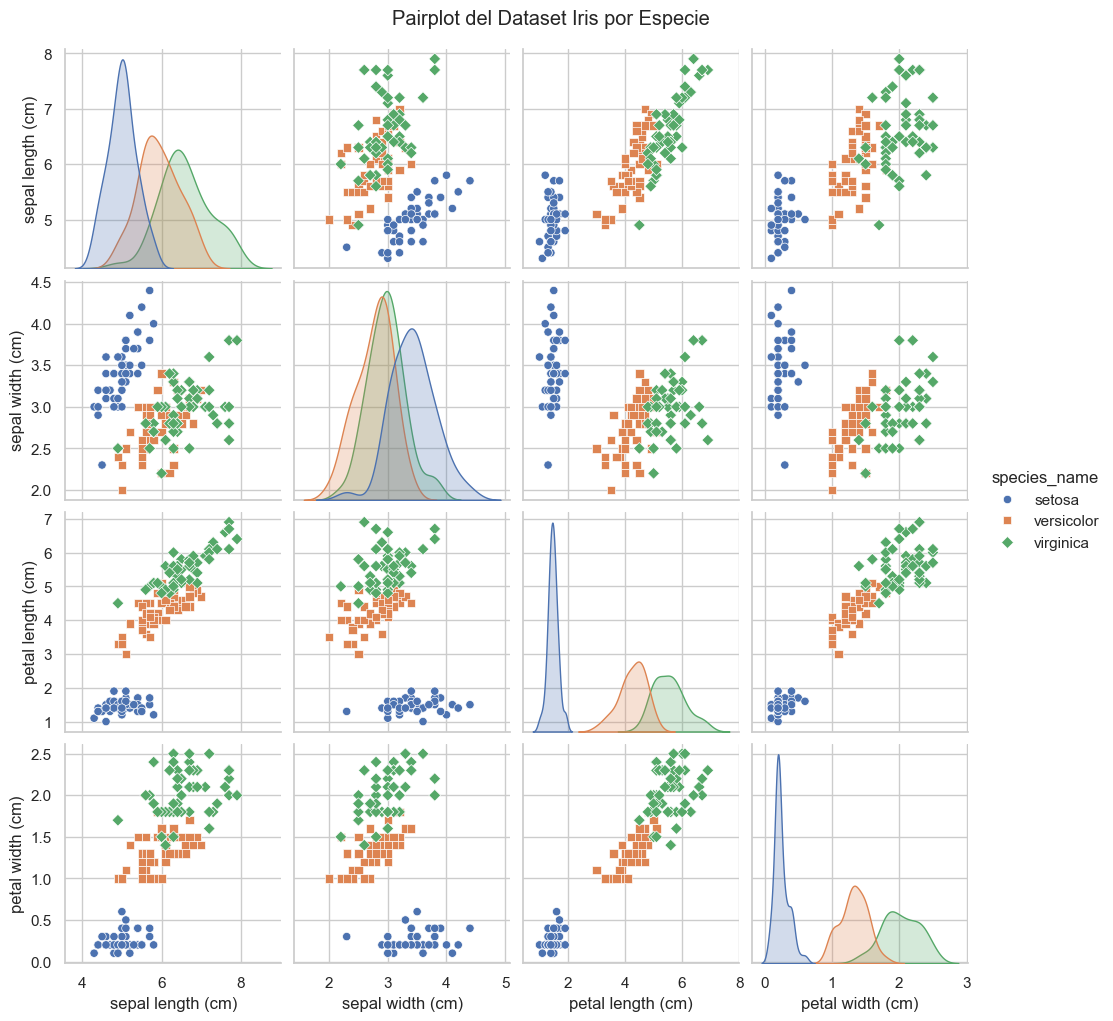

In [5]:
# 2. Gráfico de Dispersión (Scatter Chart/Plot)
# Usamos un pairplot de seaborn para ver las relaciones entre todas las características,
# coloreadas por especie.
print("\n--- Gráfico de Dispersión (Pairplot) ---")
sns.pairplot(df, hue='species_name', vars=feature_names, markers=["o", "s", "D"])
plt.suptitle("Pairplot del Dataset Iris por Especie", y=1.02)
plt.show()

**Observación del Pairplot:** Podemos ver que la clase 'setosa' (azul) es linealmente separable de las otras dos. 'Versicolor' (naranja) y 'virginica' (verde) están más superpuestas, especialmente en sus medidas de sépalo.

---

### División y Escalamiento de Datos

Antes del feature engineering, dividimos los datos y los escalamos.

In [6]:
# Dividir los datos en entrenamiento (train) y prueba (test)
# Usamos un 30% para prueba y una semilla aleatoria (random_state) para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaño de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de Prueba: {X_test.shape[0]} muestras")

# Escalamiento de Características
# kNN es sensible a la escala, por lo que estandarizamos los datos
scaler = StandardScaler()

# Ajustamos el scaler SOLO con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el scaler ya ajustado
X_test_scaled = scaler.transform(X_test)

Tamaño de Entrenamiento: 105 muestras
Tamaño de Prueba: 45 muestras


### 1.4.2 Feature Engineering (Selección de Variables)

En un proyecto complejo, esta etapa implicaría seleccionar las características (features) más relevantes para el modelo. Los métodos comunes incluyen:

1.  **Análisis de Correlación:** Eliminar características que están altamente correlacionadas entre sí (redundancia).
2.  **Pruebas Estadísticas (p.ej., ANOVA):** Evaluar la relación entre cada característica y la variable objetivo (clase).
3.  **Modelos Wrapper (p.ej., RFE - Recursive Feature Elimination):** Usar un modelo para que él mismo seleccione el subconjunto óptimo de características.
4.  **Conocimiento del Dominio:** Un experto (p.ej., un botánico) podría decirnos que las dimensiones del pétalo son más distintivas que las del sépalo.

**Para este tutorial:** El dataset Iris es muy simple y tiene solo 4 características que, como vimos en el pairplot, parecen ser todas informativas. Por lo tanto, **utilizaremos las 4 características** para entrenar nuestro modelo. El "feature engineering" principal que ya realizamos fue el **escalamiento** (StandardScaler), que es un paso de transformación de características.

---

### Entrenamiento del Modelo kNN

Ahora, creamos y entrenamos la instancia de `KNeighborsClassifier`. Elegiremos un valor de 'k' (por ejemplo, k=5) como punto de partida.

In [7]:
# Elegimos un valor para 'k'
k = 5

# 1. Crear la instancia del clasificador
knn_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

# 2. Entrenar el modelo (en kNN, esto es solo almacenar los datos)
knn_model.fit(X_train_scaled, y_train)

print(f"Modelo kNN (k={k}) entrenado exitosamente.")

Modelo kNN (k=5) entrenado exitosamente.


### 1.4.3 Prediction (Función de Predicción)

Creamos una función que recibe un nuevo patrón (las 4 medidas de una flor) y devuelve la clase predicha.

**Importante:** Esta función debe usar el `scaler` que fue entrenado (ajustado) previamente para transformar la nueva entrada antes de pasársela al modelo.

In [8]:
def predict_new_flower(pattern):
    """
    Recibe un patrón (array de 4 features: sepal_length, sepal_width, petal_length, petal_width)
    y predice la especie de Iris.
    
    Depende de 'scaler' y 'knn_model' definidos globalmente.
    """
    try:
        # Asegurarse de que el patrón sea un array de numpy
        pattern_np = np.asarray(pattern).reshape(1, -1)
        
        # 1. Escalar el patrón con el MISMO scaler usado en el entrenamiento
        pattern_scaled = scaler.transform(pattern_np)
        
        # 2. Predecir la clase (devuelve un array)
        prediction_code = knn_model.predict(pattern_scaled)
        
        # 3. Predecir las probabilidades (opcional, pero útil)
        probabilities = knn_model.predict_proba(pattern_scaled)
        
        # 4. Obtener el nombre de la clase
        predicted_class_name = target_names[prediction_code[0]]
        
        print(f"--- Predicción para el Patrón: {pattern} ---")
        print(f"Clase Predicha: {predicted_class_name} (Código: {prediction_code[0]})")
        print(f"Probabilidades: {list(zip(target_names, probabilities[0]))}")
        
        return predicted_class_name

    except Exception as e:
        print(f"Error durante la predicción: {e}")
        return None

# --- Ejemplos de Uso ---

# Ejemplo 1: Una flor con pétalos pequeños (debería ser 'setosa')
# [sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)]
new_flower_1 = [5.1, 3.5, 1.4, 0.2]
predict_new_flower(new_flower_1)

print("\n" + "="*30 + "\n")

# Ejemplo 2: Una flor con pétalos grandes (debería ser 'virginica')
new_flower_2 = [6.7, 3.0, 5.2, 2.3]
predict_new_flower(new_flower_2)

--- Predicción para el Patrón: [5.1, 3.5, 1.4, 0.2] ---
Clase Predicha: setosa (Código: 0)
Probabilidades: [(np.str_('setosa'), np.float64(1.0)), (np.str_('versicolor'), np.float64(0.0)), (np.str_('virginica'), np.float64(0.0))]


--- Predicción para el Patrón: [6.7, 3.0, 5.2, 2.3] ---
Clase Predicha: virginica (Código: 2)
Probabilidades: [(np.str_('setosa'), np.float64(0.0)), (np.str_('versicolor'), np.float64(0.0)), (np.str_('virginica'), np.float64(1.0))]


np.str_('virginica')

### 1.4.4 Model Evaluation (Métricas)

Finalmente, evaluamos el rendimiento de nuestro modelo (k=5) usando el conjunto de prueba (`X_test_scaled` y `y_test`) que el modelo nunca ha visto.

In [9]:
# 1. Realizar predicciones sobre el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

#### Accuracy (Precisión Global)

In [10]:
# 2. Calcular el Accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"--- Accuracy (Precisión Global) ---")
print(f"Accuracy: {accuracy * 100:.2f}%")

--- Accuracy (Precisión Global) ---
Accuracy: 91.11%


**Explicación del Resultado:**
El **Accuracy** mide el porcentaje total de predicciones correctas. Un valor de (por ejemplo) 100% significa que el modelo clasificó correctamente todas las flores en el conjunto de prueba, lo cual es un rendimiento excelente. (Nota: tu resultado puede ser ligeramente diferente, como 97.78%, dependiendo de la división).

---

#### Matriz de Confusión


--- Matriz de Confusión (k=5) ---
Filas: Valor Real / Columnas: Valor Predicho



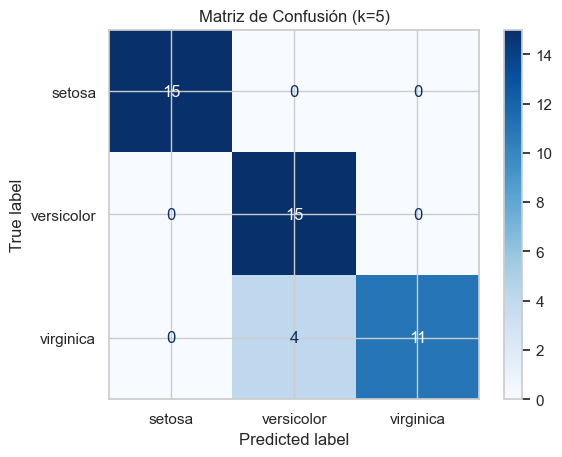

In [11]:
# 3. Calcular la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

print(f"\n--- Matriz de Confusión (k={k}) ---")
print("Filas: Valor Real / Columnas: Valor Predicho\n")

# Visualización gráfica de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Matriz de Confusión (k={k})")
plt.show()

**Explicación de la Matriz de Confusión:**
La matriz de confusión nos da un desglose detallado de los aciertos y errores por clase:

* **Diagonal Principal (de arriba-izquierda a abajo-derecha):** Muestra las predicciones **correctas**.
    * (Fila 0, Col 0): 15 'setosa' fueron correctamente clasificadas como 'setosa'.
    * (Fila 1, Col 1): 15 'versicolor' fueron correctamente clasificadas como 'versicolor'.
    * (Fila 2, Col 2): 11 'virginica' fueron correctamente clasificadas como 'virginica'.
* **Fuera de la Diagonal:** Muestra las predicciones **incorrectas** (los errores).
    * (Fila X, Col Y): Muestra cuántas muestras de la clase real X fueron incorrectamente predichas como clase Y.

En este caso (con `random_state=42`), la matriz esta indicando un 91.11% de aciertos. Si vieras un '1' en (Fila 1, Col 2), significaría que 1 'versicolor' fue clasificada erróneamente como 'virginica'.

---

#### Reporte de Clasificación

(Métrica adicional muy útil)

In [12]:
# 4. Reporte de Clasificación (Precisión, Recall, F1-Score)
print(f"\n--- Reporte de Clasificación (k={k}) ---")
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)


--- Reporte de Clasificación (k=5) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



**Explicación del Reporte:**

* **Precision:** De todas las veces que el modelo predijo una clase (p.ej., 'versicolor'), ¿qué porcentaje era correcto? (Alta precisión = bajo número de Falsos Positivos).
* **Recall (Sensibilidad):** De todas las instancias reales de una clase (p.ej., 'versicolor'), ¿qué porcentaje encontró el modelo? (Alto recall = bajo número de Falsos Negativos).
* **F1-Score:** Es la media armónica de Precision y Recall. Es útil para tener una sola métrica que balancee ambas, especialmente si las clases están desbalanceadas.
* **Support:** El número de muestras reales de esa clase en el conjunto de prueba.

## Referencias Bibliográficas

1.  **Scikit-learn (Documentación Oficial):**
    * KNeighborsClassifier: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    * Tutorial de kNN: [https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)
2.  **Libro (Referencia Clásica):**
    * James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning: with Applications in R*. Springer. (Capítulo 2.2.3: K-Nearest Neighbors).